<a href="https://colab.research.google.com/github/JoseGallardoArb/UsefullApplications/blob/main/PromMovilContagios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grafico y proyección de contagios por distrito

El presente codigo tiene por objetivo levantar la data de contagios, graficar los contagios actuales y proyectar a nivel de distrito

## 1) Importación de datos

Importación de los datos originales

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline
import warnings

df_original = pd.read_csv('https://cloud.minsa.gob.pe/s/Y8w3wHsEdYQSZRp/download',sep=";",encoding="utf-8")
df_original.head()

,FECHA_CORTE,UUID,DEPARTAMENTO,PROVINCIA,DISTRITO,METODODX,EDAD,SEXO,FECHA_RESULTADO
0,20210324,7320cabdc1aaca6c59014cae76a134e6,LIMA REGION,CAÑETE,MALA,PR,30.0,FEMENINO,20200911.0
1,20210324,e81602051997ace8340bb8c18fe24c65,LIMA REGION,OYON,OYON,PR,36.0,FEMENINO,20200911.0
2,20210324,cecdbf10074dbc011ae05b3cbd320a6f,LIMA REGION,BARRANCA,BARRANCA,PR,37.0,FEMENINO,20200911.0
3,20210324,71ecb6bccb248b0bb2ac72ed51b5e979,LIMA REGION,HUARAL,CHANCAY,PR,39.0,FEMENINO,20200911.0
4,20210324,566af4276cbe9359abe93f9aa86396c3,LIMA REGION,HUARAL,HUARAL,PR,54.0,FEMENINO,20200911.0


Formato de panel a los datos a nivel de distrito

**OJO** En la linea que da formato a los datos hay que cambiar entre `'%Y%m%d'` o `'%Y-%m-%d'`, pues depende de como sube el MINSA sus datos

In [2]:
# Generando una base a parte
df = df_original
# Drop a las observaciones sin fecha de resultado
df.dropna(subset=['FECHA_RESULTADO'], axis=0, inplace=True)
# Dando formato de fecha a la fecha de resultado de la prueba del covid
import datetime
df["FECHA_RESULTADO"] = df["FECHA_RESULTADO"].astype(int)
df["FECHA_RESULTADO"] = pd.to_datetime(df.FECHA_RESULTADO, format='%Y%m%d')
# Drop a las variables poco relevantes por el momento
df = df.drop(['FECHA_CORTE','EDAD','METODODX','SEXO'], axis=1)
# Reordenamiento de variables
df = df[['DEPARTAMENTO', 'PROVINCIA','DISTRITO','FECHA_RESULTADO','UUID']]
# Ordenando por Dep, Prov, Dist y Fecha
df = df.sort_values(by=['DEPARTAMENTO', 'PROVINCIA','DISTRITO','FECHA_RESULTADO'])
# Agrupando por Dep, Prov, Dist, Semana
df = df.groupby(by=['DEPARTAMENTO', 'PROVINCIA','DISTRITO','FECHA_RESULTADO'], as_index=False).count()
# Visualizando Baseb
df['DPD'] =  df['DEPARTAMENTO'].map(str) + '-' + df['PROVINCIA'].map(str) + '-' + df['DISTRITO'].map(str)
# Indices
df = df.set_index(['DPD', 'FECHA_RESULTADO'])
#
df['CONTMA'] = df["UUID"].rolling(window=7).mean()
df

DEPARTAMENTO PROVINCIA  ... UUID    CONTMA
DPD                     FECHA_RESULTADO                         ...               
AMAZONAS-BAGUA-ARAMANGO 2020-04-07          AMAZONAS     BAGUA  ...    1       NaN
                        2020-04-12          AMAZONAS     BAGUA  ...    1       NaN
                        2020-04-17          AMAZONAS     BAGUA  ...    1       NaN
                        2020-04-18          AMAZONAS     BAGUA  ...    1       NaN
                        2020-04-20          AMAZONAS     BAGUA  ...    1       NaN
...                                              ...       ...  ...  ...       ...
UCAYALI-PURUS-PURUS     2021-03-18           UCAYALI     PURUS  ...    1  2.285714
                        2021-03-20           UCAYALI     PURUS  ...    2  2.428571
                        2021-03-22           UCAYALI     PURUS  ...    1  2.142857
                        2021-03-23           UCAYALI     PURUS  ...    4  2.428571
                        2021-03-24           UCAYALI     PURUS  ...    2  2.428571

[142314 rows x 5 columns]

## 2) Grafico de contagios

Creación de función **contagios** que realiza el gráfico

**contagios = (Dpto,Prov,Dist,df,var)**
*   **Dpto:** Variable str en Mayusculas indicando el departamento
*   **Prov:** Variable str en Mayusculas indicando la provincia
*   **Dist:** Variable str en Mayusculas indicando el distrito
*   **df:**   Variable que indica la base de datos
*   **var:**  Variable que indica la columna de interes en la base de datos

In [3]:
def contagios(Dpto,Prov,Dist,df,variable):
  Zona = Dpto + '-' + Prov + '-' + Dist
  df[variable].xs(Zona).plot(figsize=(18, 10),color='b',linewidth=2.0)
  plt.title(Zona)
  plt.grid("major")

Uso de la función **contagios**

## 3) Proyección

Creación de función contagios que realiza el gráfico

Creación de función **proyeccion** que realiza el gráfico

**proyeccion = (Dpto,Prov,Dist,df,var)**
*   **Dpto:** Variable str en Mayusculas indicando el departamento
*   **Prov:** Variable str en Mayusculas indicando la provincia
*   **Dist:** Variable str en Mayusculas indicando el distrito
*   **df:**   Variable que indica la base de datos
*   **var:**  Variable que indica la columna de interes en la base de datos

In [4]:
def proyeccion(Dpto,Prov,Dist,df,variable):
  Zona = Dpto + '-' + Prov + '-' + Dist
  
  # Corriendo modelo
  import statsmodels.api as sm
  mod= sm.tsa.SARIMAX(df[variable].xs(Zona), order=(7, 0, 0),trend='c')
  
  # Predicción
  results = mod.fit()
  pred = results.get_forecast(steps=7)

  # Accesando a la fecha del último item
  lastdate = df.xs(Zona).tail(1).index.item()
  lastitem = df[variable].xs(Zona).tail(1).values

  # Generando nuevas fechas
  from datetime import datetime 
  from datetime import timedelta 
  lastdate_1 = df.xs(Zona).tail(1).index.item()+timedelta(days=1)
  tf = pd.date_range(start=lastdate_1, periods=7) 
  new_row = pd.DataFrame([lastitem],columns=['Mean'],index=[lastdate])

  # Generando serie de la media
  mean = pred.predicted_mean
  f_mean = pd.DataFrame(mean.values,columns=['Mean'],index=tf)
  new_row = pd.DataFrame([lastitem],columns=['Mean'],index=[lastdate])
  n_mean = pd.concat([pd.DataFrame(new_row),f_mean])

  # Intervalo de confianza = 1 desviacipon estandar por arriba y por abajo a la proyección OJO: dice 95 porque esta reciclado
  ci = pred.conf_int(alpha = .36) # Default 95%
  f_predci = f_mean = pd.DataFrame(ci.values,columns=['lower CONTMA', 'upper CONTMA'],index=tf)

  #Variable auxiliar
  new_rowci = pd.DataFrame([[lastitem[0],lastitem[0]]],columns=['lower CONTMA', 'upper CONTMA'],index=[lastdate]) # Variable auxiliar
  n_pred_ci = pd.concat([pd.DataFrame(new_rowci),f_predci])
  
  # Grafico
  ax = df[variable].xs(Zona).plot(figsize=(18, 10),color='b',linewidth=2.0)
  n_mean.plot(ax=ax,color='r',linewidth=2.0)
  ax.fill_between(n_pred_ci.index,
                  n_pred_ci.iloc[:, 0],
                  n_pred_ci.iloc[:, 1], color='r', alpha=.20)
  plt.legend(['Observado', 'Predicción de contagios'])
  plt.title(Zona)
  plt.grid("major")
  plt.show()


## 4) Uso

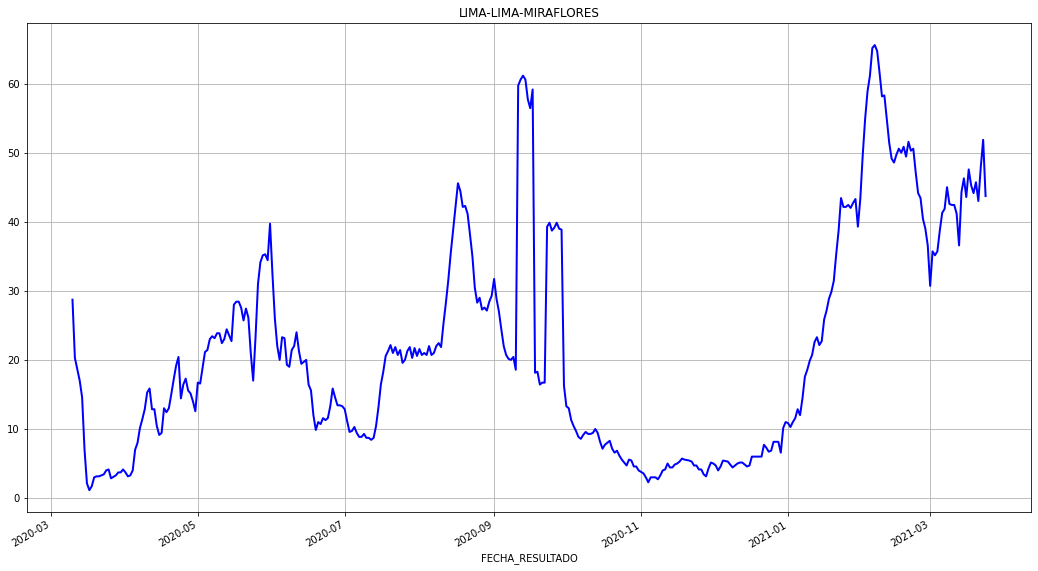

In [5]:
contagios('LIMA','LIMA','MIRAFLORES',df,'CONTMA')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


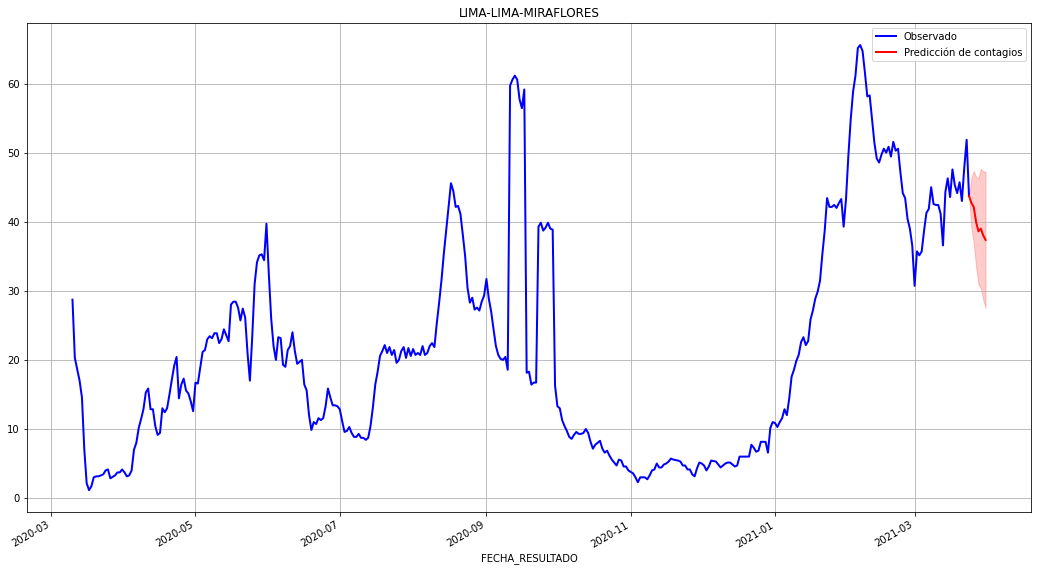

In [6]:
proyeccion('LIMA','LIMA','MIRAFLORES',df,'CONTMA')